In [1]:
%pip install torch
%pip install tqdm



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install numpy
%pip install pandas


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torchvision
%pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from typing import List, NamedTuple, Tuple, Type
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torchinfo import summary

import matplotlib.pyplot as plt



In [ ]:
%pip install

In [2]:
Loss: Type = float
Recon: Type = np.ndarray

class Loss(NamedTuple):
    loss: Loss

class Recon(NamedTuple):
    recon: Recon

class TrainValLoss(NamedTuple):
    train: List[List[Loss]]
    val: List[Loss]
    recon: List[Recon]

In [3]:
RANDOM_SEED: int = 33

image_size: tuple = (128, 128)

Use GPU if available

In [4]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [5]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Load the MVTEC dataset from local directory

In [6]:
# Transforms images to a PyTorch
tensor_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
])

# Load the MVTEC training dataset
dataset = datasets.ImageFolder(
                     root='mvtec_transistor',
                     transform=tensor_transforms,
                    )

Visualize the data

/home/i4624/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


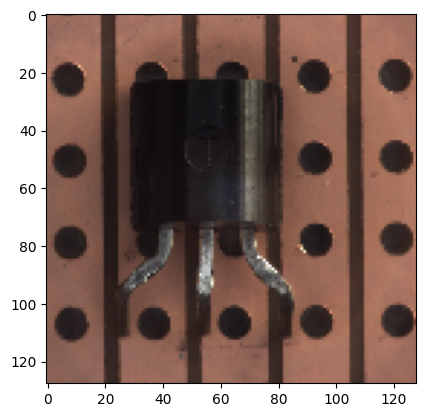

In [7]:
# show one of the image from the dataset
for data, label in dataset:
    data = data.numpy()
    image = np.rollaxis(data, 0, 3)
    plt.imshow(image)
    break

Create in-class dataset with all perfectly placed and non-defective transistor samples

In [8]:
# create an inclass dataset with all good images
inclass_label = dataset.class_to_idx['good']
inclass_dataset = deepcopy(dataset)
inclass_dataset.targets = np.array(inclass_dataset.targets)
inclass_dataset.samples = np.array(inclass_dataset.samples)
idx = inclass_dataset.targets==inclass_label
inclass_dataset.targets = inclass_dataset.targets[idx]
inclass_dataset.samples = inclass_dataset.samples[idx]

# test split is 10%
test_split = 0.1
inclass_samples = inclass_dataset.samples.__len__()
test_set_sample_count = int(inclass_samples * test_split)

# split training and validation dataset
train_dataset, val_dataset = random_split(inclass_dataset, [inclass_samples-test_set_sample_count, test_set_sample_count], generator=torch.Generator().manual_seed(RANDOM_SEED))

# DataLoader is used to load the dataset for traning
train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 8, shuffle = False)

Create out of class dataset with all  misplaced placed or missing transistor samples

In [9]:
# create an outclass dataset for all 9s images
outclass_label = dataset.class_to_idx['bad']
outclass_dataset = deepcopy(dataset)
outclass_dataset.targets = np.array(outclass_dataset.targets)
outclass_dataset.samples = np.array(outclass_dataset.samples)
idx = outclass_dataset.targets==outclass_label
outclass_dataset.targets = outclass_dataset.targets[idx]
outclass_dataset.samples = outclass_dataset.samples[idx]

# DataLoader is used to load the dataset for training
outclass_loader = DataLoader(dataset = outclass_dataset, batch_size = 8, shuffle = False)

Build training, validation, and reconstruction functions

In [10]:
def validate(model: nn.Module, val_data: DataLoader) -> Loss:
    """
    Returns the loss of the model on the validation data.
    """
    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        total_loss = 0

        # Iterate through the batches of validation data
        for batch in val_data:
            # Extract the data from the batch
            data, _ = batch
            data = data.to(DEVICE)

            # Run the model on the data to perform reconstruction
            recons = model(data)

            # Calculate the loss based on mean square error loss
            loss = nn.functional.mse_loss(data, recons)

            # Add the loss to the total loss
            total_loss += loss.item()

        # Return the average loss over all batches.
        return Loss(total_loss / len(val_data))

In [11]:
def reconstruct(model: nn.Module, data_loader: DataLoader, n_batches: int=1) -> Recon:
    """
    Returns the reconstructed image of the model on n batch of the validation data.
    """
    # Set model to evaluation mode
    model.eval()

    batch_count = 0
    outputs = None

    with torch.no_grad():
        for batch in data_loader:
            # Extract the data from the batch
            data, _ = batch

            # put the data onto the computing device
            data = data.to(DEVICE)

            # Run the model on the data to perform reconstruction
            recons = model(data)

            # detech output from computational graph, put on cpu and convert to numpy
            recons = recons.detach().cpu().numpy()

            # reshape to [batch_size, width, height, channels]
            width, height = image_size
            channels = 3
            recons = recons.reshape(-1, channels, width, height)
            recons = np.rollaxis(recons, 1, 4)

            # stack the recons onto outputs
            if(outputs is None):
                outputs = recons
            else:
                outputs = np.concatenate((outputs, recons), axis=0)
            
            # stop if batch count is reached
            batch_count += 1
            if(batch_count == n_batches):
                break

    # Return the average loss over all batches.
    return outputs

In [12]:
def train_batch(model: nn.Module, optimizer: optim.Optimizer,
                inputs: torch.Tensor) -> Loss:
    """
    Trains the model on a single batch of data.
    Returns the loss of the model on the batch.
    """
    # Set model to training mode
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Run the model on the data to perform reconstruction
    recons = model(inputs)

    # Calculate the loss based on mean square error loss
    loss = nn.functional.mse_loss(inputs, recons)

    # Backpropagate the loss
    loss.backward()

    # Update the model's weights
    optimizer.step()

    with torch.no_grad():
        return loss.item()

def train_epoch(model: nn.Module, optimizer: optim.Optimizer,
                train_data: DataLoader) -> List[Loss]:
    """
    Trains the model on a single epoch of data.
    Returns a list of the loss of the model on each batch.
    """
    batch_losses = []

    # Iterate through the batches of training data
    for batch in train_data:
        # Get the data from the batch
        data, _ = batch

        # put the data onto the computing device
        data = data.to(DEVICE)

        # Train the model on the batch with `train_batch`
        batch_loss = train_batch(model, optimizer, data)

        # Add the loss to the list
        batch_losses.append(batch_loss)
    
    # Return the list of loss
    return batch_losses

def train_loop(model: nn.Module, optimizer: optim.Optimizer,
               train_data: DataLoader, val_data: DataLoader,
               num_epochs: int = 10) -> TrainValLoss:
    """
    Trains the model on the training data for `num_epochs` epochs.
    Returns the loss of the model on the training and validation data,
    and the reconstruction of the validation data,
    taken per-batch in training and per-epoch in validation.
    """
    train_losses = []
    val_losses = []
    val_recons = []

    # Iterate through the epochs
    for epoch in tqdm(range(num_epochs)):
        # Train the model on the epoch with `train_epoch`
        train_loss = train_epoch(model, optimizer, train_data)

        # Validate the model on the validation data
        val_loss = validate(model, val_data)

        # Reconstrcut validation data using the model
        val_recon = reconstruct(model, val_data)

        # Add the loss to the list
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_recons.append(val_recon)

    # Return the lists of loss
    return TrainValLoss(train_losses, val_losses, val_recons)

Build Autoencoder network

In [13]:
encoder = nn.Sequential(
    nn.Conv2d(3, 16, 3, stride=2, padding=1),  # N, 16, 64, 64
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=2, padding=1),  # N, 32, 32, 32
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=2, padding=1),  # N, 64, 16, 16
    nn.ReLU(),
    nn.Conv2d(64, 128, 16)  # N, 128, 8, 8
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(128, 64, 16),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
    nn.Sigmoid()
)

model = nn.Sequential(
    encoder,
    decoder
)


In [14]:
width, height = image_size
channels = 3
summary(model, input_size=(1, channels, width, height))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3, 128, 128]          --
├─Sequential: 1-1                        [1, 128, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 32, 32, 32]           4,640
│    └─ReLU: 2-4                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 64, 16, 16]           18,496
│    └─ReLU: 2-6                         [1, 64, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 128, 1, 1]            2,097,280
├─Sequential: 1-2                        [1, 3, 128, 128]          --
│    └─ConvTranspose2d: 2-8              [1, 64, 16, 16]           2,097,216
│    └─ReLU: 2-9                         [1, 64, 16, 16]           --
│    └─ConvTranspose2d: 2-10             [1, 32, 32, 32]       

Training a model to reconstruct the digit 1

In [15]:
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001,
                                weight_decay=1e-5)
    
history = train_loop(model, optimizer, train_loader,
                     val_loader, num_epochs=20)

100%|██████████| 20/20 [05:11<00:00, 15.60s/it]


Show Training and Validation Loss

In [16]:
training_history = pd.DataFrame([loss for batch_losses in history.train for loss in batch_losses], columns=Loss._fields)
training_history['epoch'] = training_history.index / len(train_loader)
validation_history = pd.DataFrame.from_records(history.val, columns=Loss._fields)
validation_history['epoch'] = validation_history.index + 1

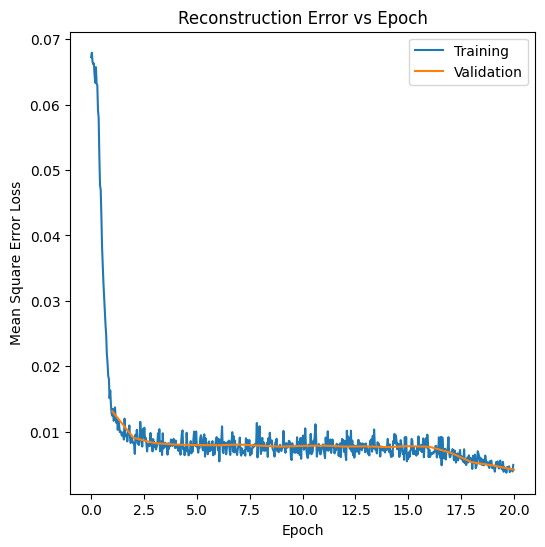

In [17]:
plt.figure(figsize=(6, 6))
plt.plot(training_history['epoch'], training_history['loss'], label='Training')
plt.plot(validation_history['epoch'], validation_history['loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error Loss')
plt.title('Reconstruction Error vs Epoch')
plt.legend()

Show the reconstruction history for a batch of validation samples

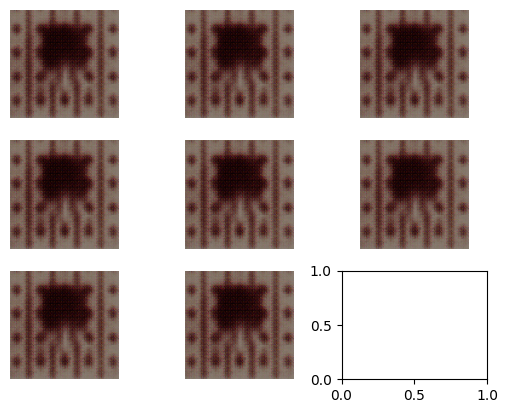

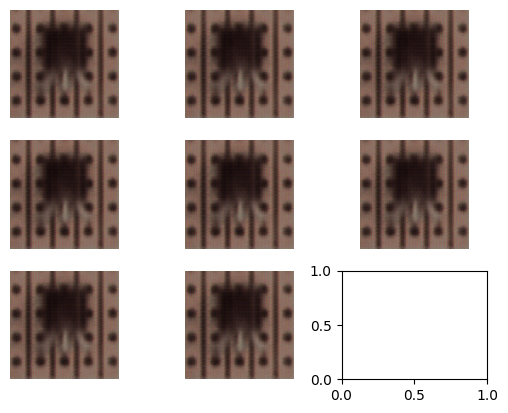

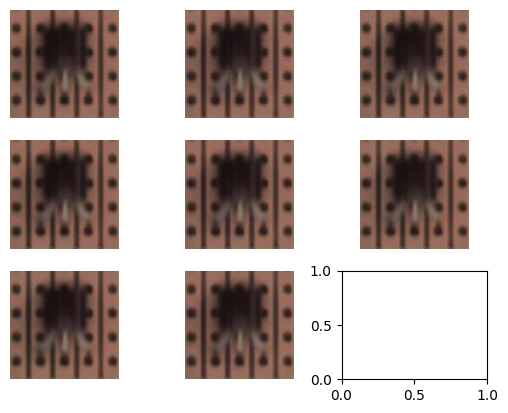

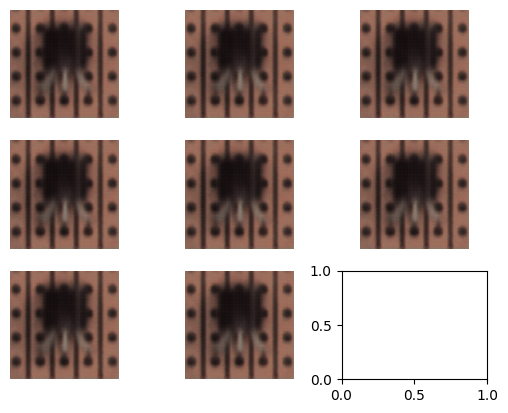

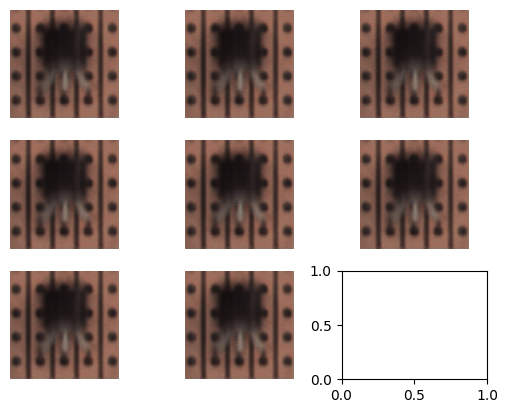

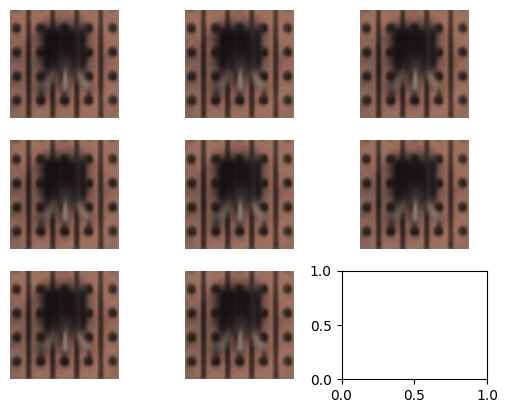

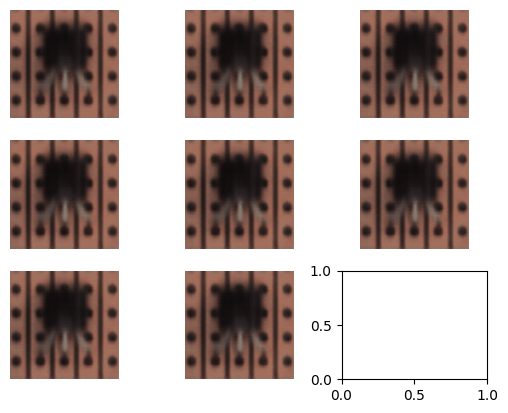

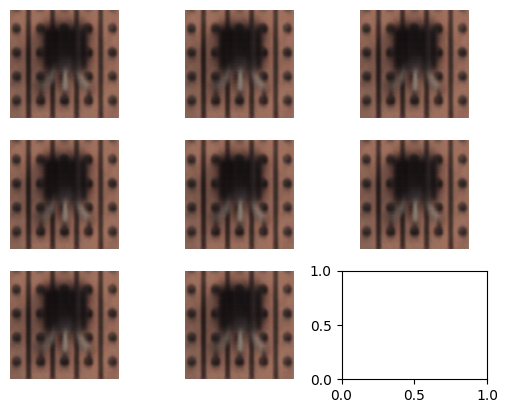

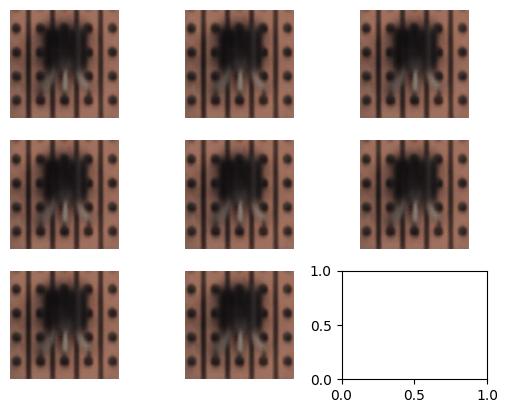

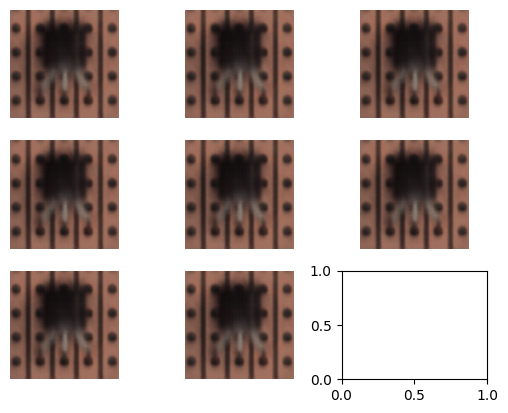

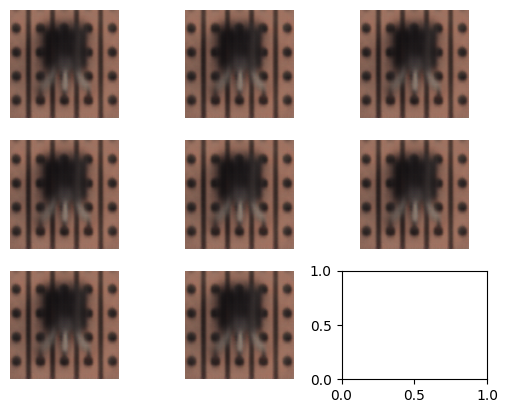

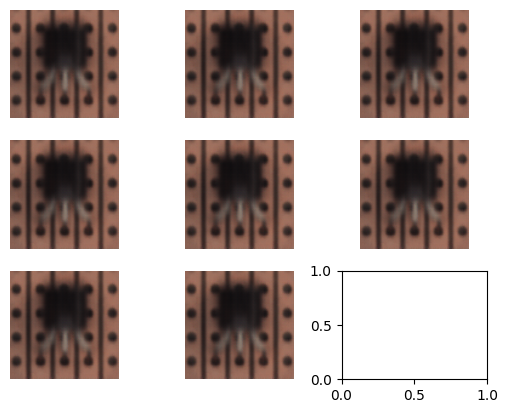

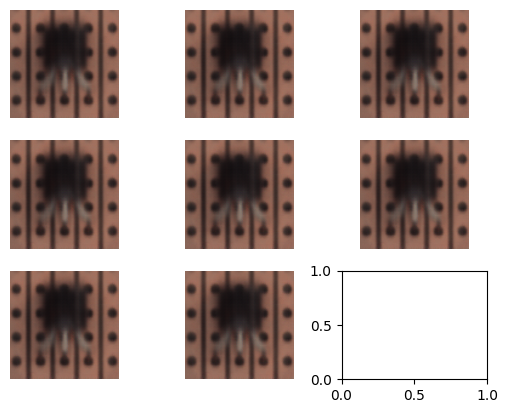

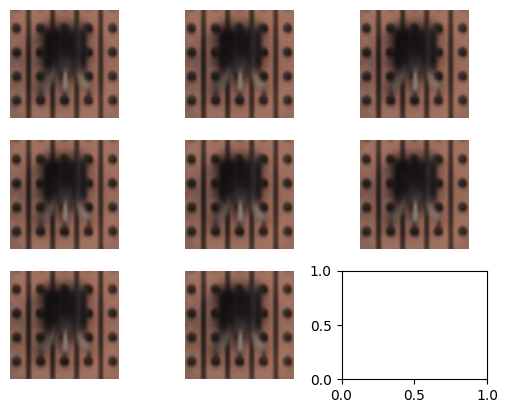

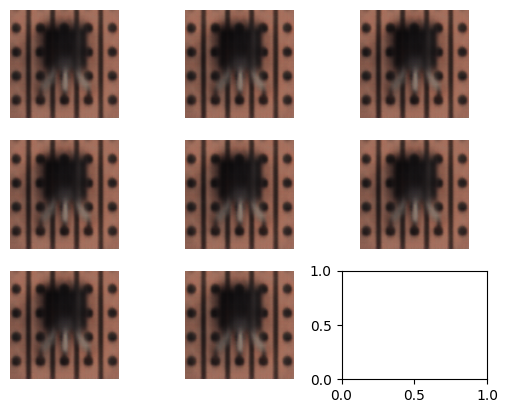

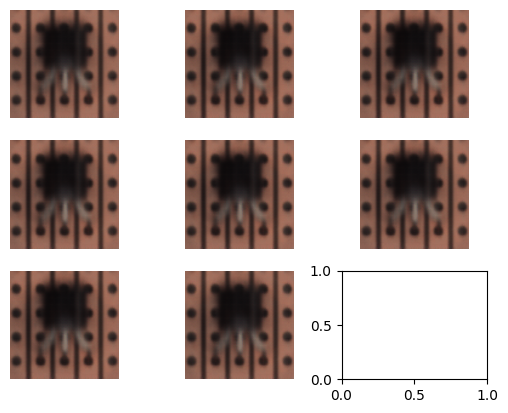

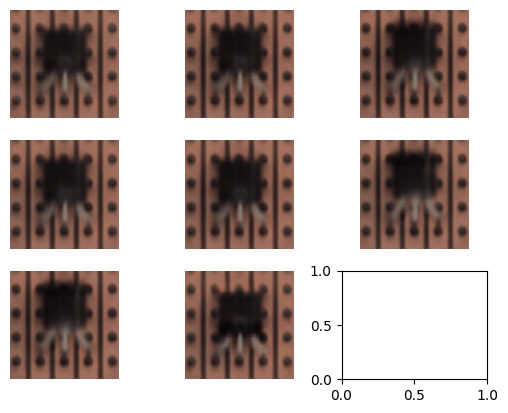

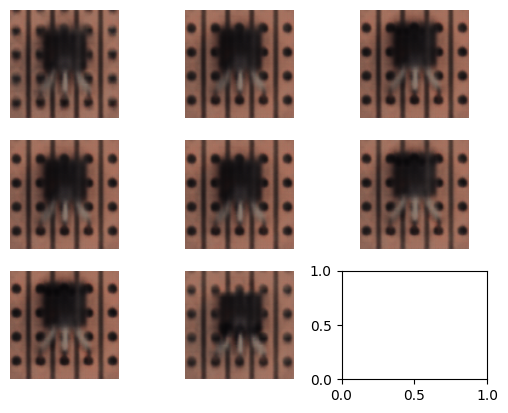

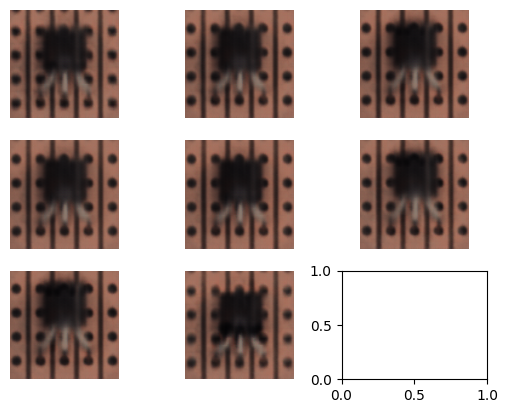

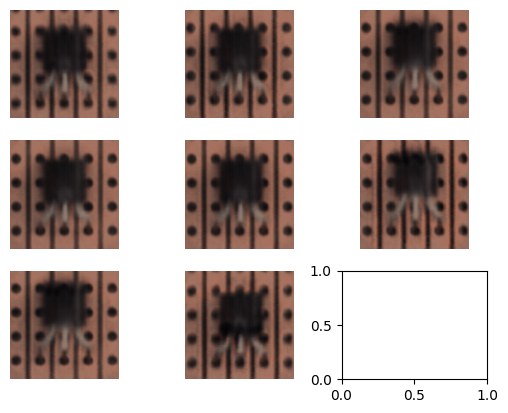

In [18]:
for recons in history.recon:
    items = int(np.ceil(np.sqrt(recons.shape[0])))
    fig, axes = plt.subplots(items, items)

    for ax, recon in zip(axes.ravel(), recons):
        ax.imshow(recon)
        ax.axis('off')
    plt.show()

Perform the reconstruction for the validation dataset and check the reconstruction difference values
- Reconstruct the  in-class samples with the trained model
- Calculate the difference map between the original image and reconstructed image
- Plot the n samples with the highest reconstruction difference

In [19]:
def calculate_recon_diff(recon: np.ndarray, original: np.ndarray) -> np.ndarray:
    """
    Calculate the pixel absolute difference between the reconstructed 
    and original images
    """
    diff = np.absolute(recon - original)
    return diff

In [20]:
def create_recon_df(recon: np.ndarray, original: np.ndarray, diff: np.ndarray) -> pd.DataFrame:
    """
    Create data frame with reconstructed, original and difference images
    and sort the rows by the reconstruction difference
    """
    temp_dict = {
        'recon': list(recon),
        'original': list(original),
        'diff': list(diff),
        'sum_diff': np.sum(diff, axis=(1,2,3))
    }

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.sort_values(by=['sum_diff'], ascending=False)
    return df

In [21]:
def visualize_reconstruct_diff(df: pd.DataFrame, n_samples: int=10) -> None:
    """
    Plot the n samples with the highest reconstruction difference
    """
    for i in range(n_samples):
        row = df.iloc[i]
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(row['recon'])
        axs[1].imshow(row['original'])
        axs[2].imshow(row['diff'])

        axs[0].set_title('Reconstruct')
        axs[1].set_title('Original')
        axs[2].set_title(f"Difference:\n{row['sum_diff']}")
        plt.show()

In [22]:
width, height = image_size
channels = 3

inclass_reconstruct = reconstruct(model, val_loader, len(val_loader))
inclass_original = np.concatenate([np.rollaxis(data.numpy(), 1, 4) for data, _ in val_loader], axis=0)
inclass_diff = calculate_recon_diff(inclass_reconstruct, inclass_original)
val_df = create_recon_df(inclass_reconstruct, inclass_original, inclass_diff)

/home/i4624/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


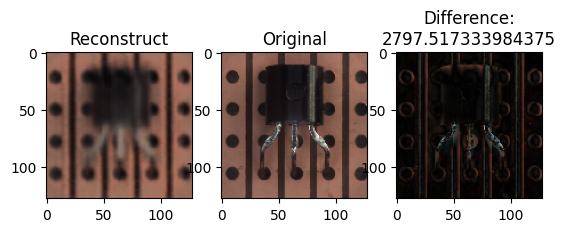

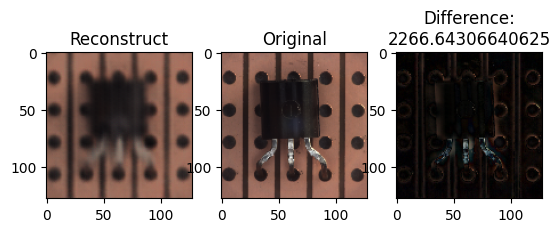

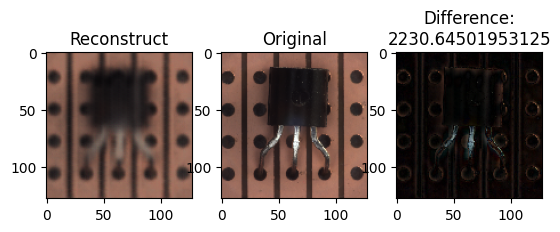

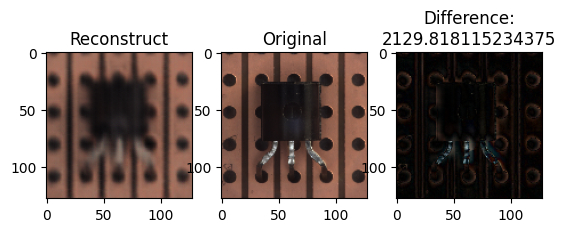

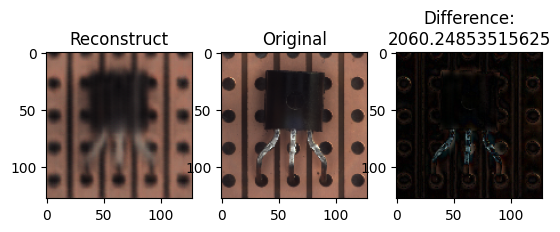

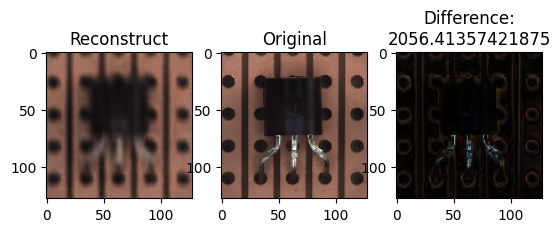

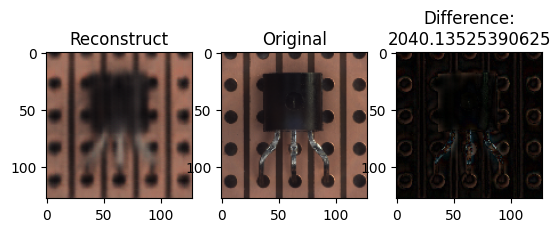

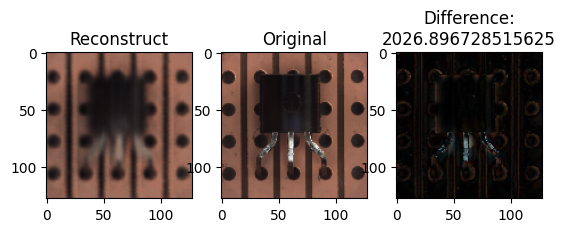

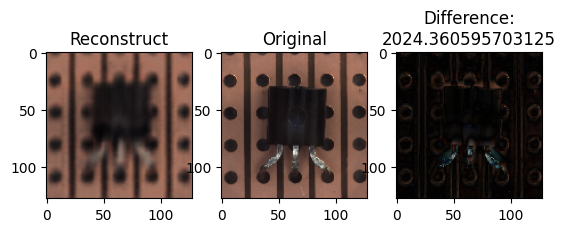

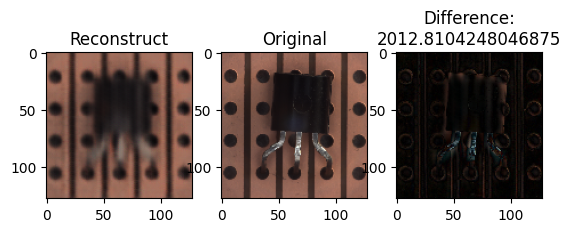

In [23]:
visualize_reconstruct_diff(val_df)

Use the trained model as anomaly detector to show the which part the image does not look like the perfectly placed and non-defective transistors
- Reconstruct the  out of class samples with the trained model
- Calculate the difference map between the original image and reconstructed image
- Plot the n samples with the highest reconstruction difference

In [85]:
width, height = image_size
channels = 3

outclass_reconstruct = reconstruct(model, outclass_loader, len(outclass_loader))
outclass_original = np.concatenate([np.rollaxis(data.numpy(), 1, 4) for data, _ in outclass_loader], axis=0)
outclass_diff = calculate_recon_diff(outclass_reconstruct, outclass_original)
outclass_df = create_recon_df(outclass_reconstruct, outclass_original, outclass_diff)

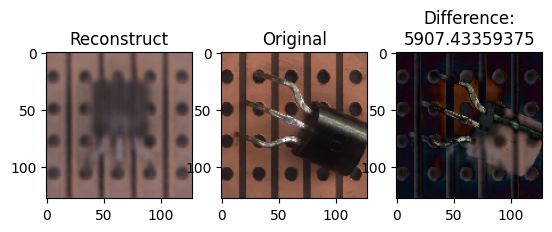

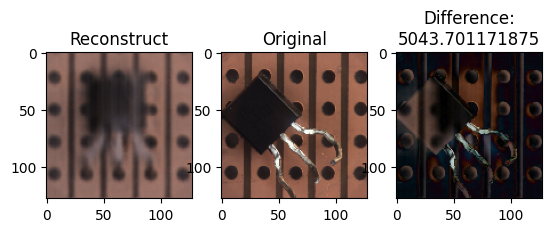

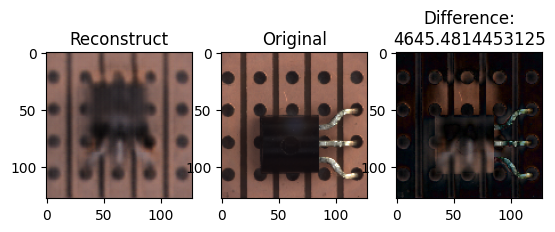

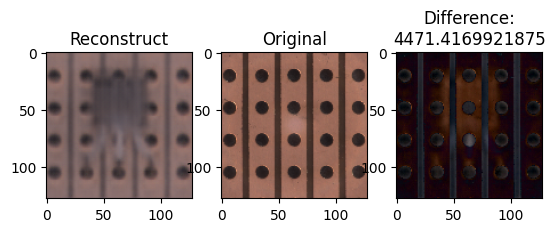

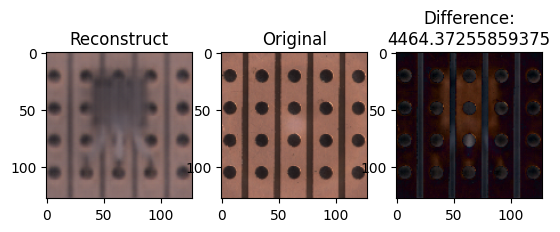

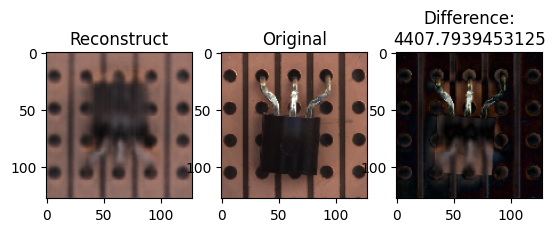

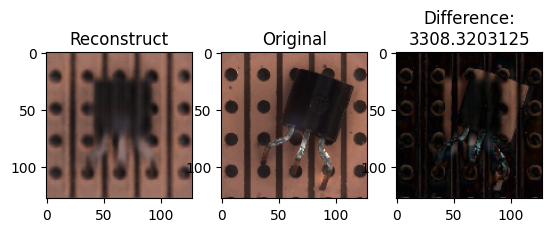

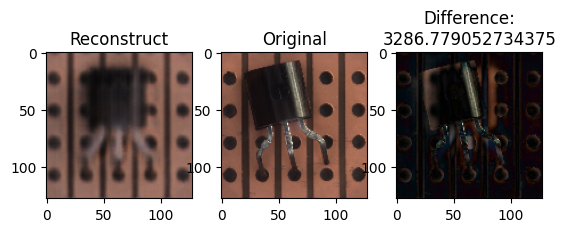

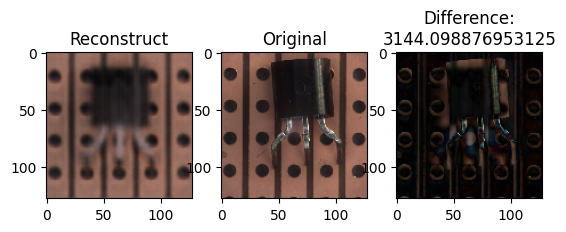

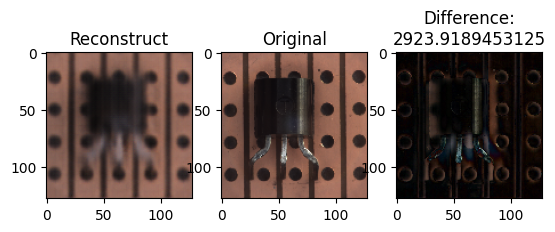

In [86]:
visualize_reconstruct_diff(outclass_df)

From the histogram, we see that the out of class samples have a higher reconstruction error for at least 7 of the samples.

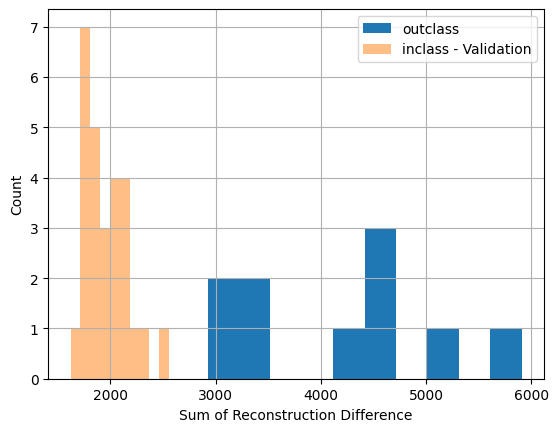

In [87]:
outclass_df['sum_diff'].hist(label='outclass')
val_df['sum_diff'].hist(label='inclass - Validation', alpha=0.5)
plt.xlabel('Sum of Reconstruction Difference')
plt.ylabel('Count')
plt.legend()